In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../database/data_final.csv')

In [3]:
data.head()

,сумма_выдачи,количество,дата_выдачи,дата_погашения,срок_кредита,цикл,кредитный_продукт,сфера_кредита,код_цель,цель_кредита,...,количество_поручителей,количество_залогов,залоговая_стоимость,наименование_залога,возраст,пол,регион_город,должность,местность,cumulative_days
0,2500000.0,1,2018-01-04,2019-01-04,12,1,Хазина (Кис?а муддатли),Микрозаем (Краткосрочный),195,Миграция,...,1,0,0,NaN,50,Ж,КУКОН ШАХРИ,Тарбиячи,Urban - Городской,3
1,6000000.0,1,2018-01-04,2018-10-04,12,1,Сармоя (Киска муддатли),Микрозаем (Краткосрочный),195,Миграция,...,0,1,8600000,автотранспорт,27,М,КУКОН ШАХРИ,шофёр,Urban - Городской,13
2,5000000.0,1,2018-01-05,2019-01-04,12,1,Хазина (Кис?а муддатли),Микрозаем (Краткосрочный),195,Миграция,...,1,0,0,NaN,53,Ж,КУКОН ШАХРИ,Укитувчи,Urban - Городской,10
3,2000000.0,1,2018-01-05,2018-09-05,12,1,Имкон (Киска муддатли),Микрозаем (Краткосрочный),195,Миграция,...,0,1,2266000,тилло,45,Ж,БЕШАРИК ТУМАНИ,Укитувчи,Rural - сельский,1
4,1400000.0,1,2018-01-05,2018-10-05,12,1,Имкон (Киска муддатли),Микрозаем (Краткосрочный),195,Миграция,...,0,1,1617000,тилло,31,М,КУКОН ШАХРИ,уста,Urban - Городской,1


In [4]:
#feature columns
selected_features = ['сумма_выдачи', 'должность', 'залоговая_стоимость', 
                     'кредитный_продукт', 'возраст', 'регион_город', 'cumulative_days']

In [5]:
#categorial and numericacl values
categorical_columns = ['должность', 'кредитный_продукт', 'регион_город']
numerical_columns = ['сумма_выдачи', 'залоговая_стоимость', 'возраст', 'cumulative_days']

In [6]:

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])


In [7]:

X = preprocessor.fit_transform(data[selected_features])

In [8]:
if hasattr(X, "toarray"):  
    X = X.toarray()

In [9]:
#optimal value for k
sse = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

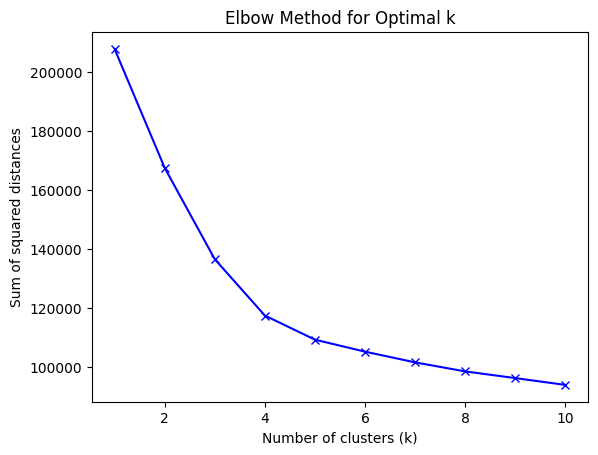

In [10]:
plt.plot(k_values, sse, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal k')
plt.show()

In [9]:
optimal_k = 4 

In [10]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['cluster_label'] = kmeans.fit_predict(X)

In [11]:
#status of clients
data['target'] = np.where(data['cumulative_days'] > 60, 1, 0)  # 1: Bad, 0: Good

In [12]:
X_with_clusters = pd.concat([pd.DataFrame(X), data['cluster_label']], axis=1)
y = data['target']

In [15]:
#new
# Feature engineering for weights
data['loan_amount_weight'] = data['сумма_выдачи'].apply(lambda x: 1 if x > 5000000 else 0.8)
# data['collateral_weight'] = data['наименование_залога'].apply(lambda x: 0.7 if 'тилло' in x.lower() else 0.63)
data['days_overdue_weight'] = data['cumulative_days'].apply(lambda x: 0.6 if x > 60 else 0.48)
data['loan_duration_weight'] = data['срок_кредита'].apply(lambda x: 0.45 if x == 12 else 0.34)
# data['client_type_weight'] = data['должность'].apply(lambda x: 0.3 if x > 1 else 0.23)
data['age_weight'] = data['возраст'].apply(lambda x: 0.17 if x > 30 else 0.1)


In [16]:
# new Calculate total weight
data['total_weight'] = data['loan_amount_weight']  * \
                       data['days_overdue_weight'] * data['loan_duration_weight']* \
                       data['age_weight']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_with_clusters, y, test_size=0.3, random_state=42)

In [18]:
#new
train_weights = data.loc[X_train.index, 'total_weight']


In [19]:
train_weights

15923    0.027744
2814     0.029376
15915    0.034680
18869    0.017280
21338    0.036720
           ...   
29802    0.027744
5390     0.017280
860      0.029376
15795    0.036720
23654    0.020400
Name: total_weight, Length: 21820, dtype: float64

In [20]:
if hasattr(X_train, "toarray"):
    X_train = X_train.toarray()
if hasattr(X_test, "toarray"):
    X_test = X_test.toarray()

In [21]:
model = RandomForestClassifier(random_state=42)
#nnew
model.fit(X_train, y_train, sample_weight=train_weights)
# model.fit(X_train, y_train)

/home/jasurkhon/.local/share/virtualenvs/fintech-FRh8gAjU/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


RandomForestClassifier(random_state=42)

In [22]:
y_pred = model.predict(X_test)

/home/jasurkhon/.local/share/virtualenvs/fintech-FRh8gAjU/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [23]:
#evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7935
           1       1.00      1.00      1.00      1417

    accuracy                           1.00      9352
   macro avg       1.00      1.00      1.00      9352
weighted avg       1.00      1.00      1.00      9352

Accuracy Score: 1.0


In [24]:
y_train_pred = model.predict(X_train)

#training performance metrics
print("Training Classification Report:\n", classification_report(y_train, y_train_pred))
print("Training Accuracy Score:", accuracy_score(y_train, y_train_pred))

/home/jasurkhon/.local/share/virtualenvs/fintech-FRh8gAjU/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     18391
           1       1.00      1.00      1.00      3429

    accuracy                           1.00     21820
   macro avg       1.00      1.00      1.00     21820
weighted avg       1.00      1.00      1.00     21820

Training Accuracy Score: 1.0


In [25]:
from sklearn.model_selection import cross_val_score

#cross-validation
cv_scores = cross_val_score(model, X_with_clusters, y, cv=5) 

print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", np.mean(cv_scores))


/home/jasurkhon/.local/share/virtualenvs/fintech-FRh8gAjU/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/jasurkhon/.local/share/virtualenvs/fintech-FRh8gAjU/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/jasurkhon/.local/share/virtualenvs/fintech-FRh8gAjU/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/jasurkhon/.local/share/virtualenvs/fintech-FRh8gAjU/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Fea

Cross-Validation Scores: [0.99326383 1.         1.         1.         0.97609881]
Mean Cross-Validation Score: 0.9938725292321721


/home/jasurkhon/.local/share/virtualenvs/fintech-FRh8gAjU/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [26]:
test_samples = X_test[:10] 
true_labels = y_test[:10]
predicted_labels = model.predict(test_samples)

for i in range(len(test_samples)):
    print(f"Sample {i}: True Label = {true_labels.iloc[i]}, Predicted Label = {predicted_labels[i]}")


Sample 0: True Label = 1, Predicted Label = 1
Sample 1: True Label = 1, Predicted Label = 1
Sample 2: True Label = 0, Predicted Label = 0
Sample 3: True Label = 0, Predicted Label = 0
Sample 4: True Label = 0, Predicted Label = 0
Sample 5: True Label = 0, Predicted Label = 0
Sample 6: True Label = 0, Predicted Label = 0
Sample 7: True Label = 0, Predicted Label = 0
Sample 8: True Label = 0, Predicted Label = 0
Sample 9: True Label = 0, Predicted Label = 0


/tmp/ipykernel_2489/1728642875.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  true_labels = y_test[:10]
/home/jasurkhon/.local/share/virtualenvs/fintech-FRh8gAjU/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [27]:
#feature importance
importances = model.feature_importances_

In [28]:
one_hot_encoder = preprocessor.named_transformers_['cat']
encoded_categorical_features = one_hot_encoder.get_feature_names_out(categorical_columns)

In [29]:
feature_names = numerical_columns + list(encoded_categorical_features) + ['cluster_label']

In [30]:
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

In [31]:
for col in categorical_columns:
    matching_features = feature_importance_df[feature_importance_df['Feature'].str.contains(col)]
    total_importance = matching_features['Importance'].sum()
    feature_importance_df = feature_importance_df.append({'Feature': col, 'Importance': total_importance}, ignore_index=True)


/tmp/ipykernel_2489/943418654.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importance_df = feature_importance_df.append({'Feature': col, 'Importance': total_importance}, ignore_index=True)
/tmp/ipykernel_2489/943418654.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importance_df = feature_importance_df.append({'Feature': col, 'Importance': total_importance}, ignore_index=True)
/tmp/ipykernel_2489/943418654.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importance_df = feature_importance_df.append({'Feature': col, 'Importance': total_importance}, ignore_index=True)


In [32]:
feature_importance_original = feature_importance_df[feature_importance_df['Feature'].isin(selected_features)]

In [33]:
feature_importance_original = feature_importance_original.sort_values(by='Importance', ascending=False)

In [34]:
print("Feature Importances of the selected Features:\n", feature_importance_original)

Feature Importances of the selected Features:
                  Feature  Importance
3        cumulative_days    0.477655
0           сумма_выдачи    0.114607
1    залоговая_стоимость    0.090422
360    кредитный_продукт    0.074936
359            должность    0.022567
361         регион_город    0.021132
2                возраст    0.019957


In [39]:
feature_importance_original.to_csv("feature_importance.csv", index=False)

In [35]:
import joblib
joblib.dump(model, 'credit_model1.pkl')
joblib.dump(preprocessor, 'preprocessor1.pkl')
joblib.dump(kmeans, 'kmeans1.pkl')

['kmeans1.pkl']